# LANL Host Dataset

### Article : https://www.worldscientific.com/doi/pdf/10.1142/9781786345646_001

Notes:

"The events from the host logs included in the data set are all related to authentication and process activity on each machine"

### Pour obtenir le dataset:
1- https://csr.lanl.gov/data/2017/#citing : donner mail, obtenir le lien

2- https://csr.lanl.gov/data-fence/... 10 chiffres.../... token... iXYXXbqw15UugRnZALCZ2Y8dvEk=... /unified-host-network-dataset-2017/wls.html pour avoir l'index avec tous les fichiers compressés

3- download : for i in $(seq -w 1 90); do wget -c https://csr.lanl.gov/data-fence/...10 chiffres.../...token.../unified-host-network-dataset-2017/wls/wls_day-$i.bz2; done

4- decompress, as required : bzip2 -dk filename.bz2

### EventID : 

EventID         Description

Authentication events

4768            Kerberos authentication ticket was requested (TGT)

4769            Kerberos service ticket was requested (TGS)

4770            Kerberos service ticket was renewed

4774            An account was mapped for logon

4776            Domain controller attempted to validate credentials

4624            An account successfully logged on, see Logon Types

4625            An account failed to logon, see Logon Types

4634            An account was logged off, see Logon Types

4647            User initiated logoff

4648            A logon was attempted using explicit credentials

4672            Special privileges assigned to a new logon

4800            The workstation was locked

4801            The workstation was unlocked

4802            The screensaver was invoked

4803            The screensaver was dismissed

Process events

4688            Process start

4689            Process end

System events

4608            Windows is starting up

4609            Windows is shutting down

1100            Event logging service has shut down (often recorded instead of EventID 4609)


Detailed description : - EventID : https://learn.microsoft.com/en-us/windows-server/identity/ad-ds/plan/appendix-l--events-to-monitor


### Logon Types for EventIDs: 4624, 4625 and 4634

LogonTypes (EventIDs: 4624, 4625 and 4634)

2 — Interactive

3 — Network

4 — Batch

12 — Cached Remote-Interactive

5 — Service

9 — New Credentials

7 — Unlock

10 — Remote Interactive

8 — Network Clear Text 11 — Cached Interactive

0 — Used only by the system account

### Host Log Fields

. Time: The epoch time of the event in seconds.

• EventID: Four digit integer corresponding to the event id of the record.

• LogHost: The hostname of the computer that the event was recorded on.In the case of directed authentication events, the LogHost will correspond to the computer that the authentication event is terminating at (destination computer).

• LogonType: Integer corresponding to the type of logon, see Table 2.

• LogonTypeDescription: Description of the LogonType, see Table 2.

• UserName: The user account initiating the event. If the user ends in $, then it corresponds to a computer account for the specified computer.

• DomainName: Domain name of UserName.

• LogonID: A semi-unique (unique between current sessions and LogHost)number that identifies the logon session just initiated. Any events logged subsequently during this logon session should report the same LogonID through to the logoff event.

• SubjectUserName: For authentication mapping events, the user account specified by this field is mapping to the user account in UserName.

• SubjectDomainName: Domain name of SubjectUserName.

• SubjectLogonID: See LogonID.

• Status: Status of the authentication request. “0 × 0” means success otherwise failure; failure codes for the appropriate EventID are available online.f

• Source: For authentication events, this will correspond to the the computer where the authentication originated (source computer), if it is a local logon event then this will be the same as the LogHost.

• ServiceName: The account name of the computer or service the user is requesting the ticket for.

• Destination: This is the server the mapped credential is accessing. This may indicate the local computer when starting another process with new account credentials on a local computer.

• AuthenticationPackage: The type of authentication occurring including Negotiate, Kerberos, NTLM plus a few more.

• FailureReason: The reason for a failed logon.

• ProcessName: The process executable name, for authentication events this is the process that processed the authentication event. ProcessNames may include the file type extensions (i.e., exe).

• ProcessID: A semi-unique (unique between currently running processes AND LogHost) value that identifies the process. ProcessID allows you to correlate other events logged in association with the same process through to the process end.

• ParentProcessName: The process executable that started the new process. ParentProcessNames often do not have file extensions like ProcessName but can be compared by removing file extensions from the name.

• ParentProcessID: Identifies the exact process that started the new process. Look for a preceding event 4688 with a ProcessID that matches this ParentProcessID.

In [1]:
import json
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

from sklearn.svm import OneClassSVM

2024-07-31 16:32:53.073050: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 16:32:53.095555: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 16:32:53.176250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 16:32:53.309762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 16:32:53.352021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 16:32:53.450636: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# affiche le nombre de lignes de chaque fichier

dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
liste_fichiers = [ 'wls_day-01.json', 'wls_day-02.json']

for filename in liste_fichiers:
    filepath = dirpath + filename
    with open(filepath) as f:
        ctr_lignes = sum(1 for line in f)
    print(f'{filename} contient {ctr_lignes} lignes')

wls_day-01.json contient 55609151 lignes
wls_day-02.json contient 64844144 lignes


In [3]:
# lit le fichier de 12+ Gb ligne par ligne

dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
filename = 'wls_day-02.json'

filepath = dirpath + filename

In [4]:
# lit les N_SAMPLES premières lignes du fichier wls_day-01.json décompressé

N_SAMPLES = 10
with open(filepath, 'r') as f:
    for i in range(N_SAMPLES):
        line = f.readline()
        # print(line)
        # print(json.dumps(line, sort_keys=True, indent=4))
        obj_json = json.loads(line)
        print(obj_json)

{'UserName': 'Comp883524$', 'EventID': 4688, 'LogHost': 'Comp883524', 'LogonID': '0x3e7', 'DomainName': 'Domain001', 'ParentProcessName': 'svchost', 'ParentProcessID': '0x35c', 'ProcessName': 'wmiprvse.exe', 'Time': 86400, 'ProcessID': '0x1db4'}
{'UserName': 'User805641', 'EventID': 4688, 'LogHost': 'Comp836249', 'LogonID': '0x45a5847', 'DomainName': 'Domain001', 'ParentProcessName': 'Proc028501', 'ParentProcessID': '0x3a8c', 'ProcessName': 'Proc542756.exe', 'Time': 86400, 'ProcessID': '0x3314'}
{'UserName': 'Comp397468$', 'EventID': 4688, 'LogHost': 'Comp397468', 'LogonID': '0x3e7', 'DomainName': 'Domain001', 'ParentProcessName': 'services', 'ParentProcessID': '0x2b8', 'ProcessName': 'svchost.exe', 'Time': 86400, 'ProcessID': '0xc770'}
{'UserName': 'Comp916004$', 'EventID': 4672, 'LogHost': 'Comp916004', 'LogonID': '0x32bba0c8', 'DomainName': 'Domain001', 'Time': 86400}
{'UserName': 'Comp916004$', 'EventID': 4624, 'LogHost': 'Comp916004', 'LogonID': '0x32bba0c8', 'DomainName': 'Domain

In [5]:
# liste des events correspondant à des évènements d'authentification

authentication_events = {
    4768 : 'Kerberos authentication ticket was requested (TGT)',
    4769 : 'Kerberos service ticket was requested (TGS)',
    4770 : 'Kerberos service ticket was renewed',
    4774 : 'An account was mapped for logon',
    4776 : 'Domain controller attempted to validate credentials',
    4624 : 'An account successfully logged on, see Logon Types',
    4625 : 'An account failed to logon, see Logon Types',
    4634 : 'An account was logged off, see Logon Types',
    4647 : 'User initiated logoff',
    4648 : 'A logon was attempted using explicit credentials',
    4672 : 'Special privileges assigned to a new logon',
    4800 : 'The workstation was locked',
    4801 : 'The workstation was unlocked',
    4802 : 'The screensaver was invoked',
    4803 : 'The screensaver was dismissed'
}

liste_authentication_events = list(authentication_events.keys())

In [6]:
# combien d'EventIDs correspondant à un évènement d'authentification ? Environ 57% de tous les évènements

total = 0
auth = 0

N_SAMPLES = 1000

with open(filepath, 'r') as f:
    for i in range(N_SAMPLES):
        line = f.readline()
        obj_json = json.loads(line)
        if obj_json.get('EventID') in liste_authentication_events:
            auth += 1
        total += 1
        print(f'{total} lignes traitées', end='\r', flush=True)

print()
print(f'{total} evènements, dont {auth} pour authentification ({auth/total*100:.2f}%)')

1000 lignes traitées
1000 evènements, dont 511 pour authentification (51.10%)


In [7]:
# on va maintenant éxtraire des fichiers avec un nombre N de lignes

N_SAMPLES = [1000, 10000, 20000, 40000]

#-- fichier json complet ---
dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
filename = 'wls_day-02.json'
filepath = dirpath + filename

presents = os.listdir(dirpath)

In [8]:
#-- boucle extraction --
for n_samples in N_SAMPLES:
    subset_filename = 'wls_day-02_subset_all_events_' + f'{n_samples}' + '.json'  # fichier dans lequel on va écrire les n lignes lignes
    if subset_filename in presents:
        print(f'{subset_filename} déjà présent')
    else:
        print(f'extrait {subset_filename}')
        subset_filepath = dirpath + subset_filename
        ctr = 0  # compteur de lignes
        print("\n" + f"Extrait fichier de {n_samples} évènements")
        with open(filepath, 'r') as f:
            while ctr < n_samples:
                    line = f.readline()
                    obj_json = json.loads(line)
                    ctr += 1
                    print(f'{ctr} évènements extraits', end='\r', flush=True)
                    with open(subset_filepath, 'a') as g:
                        g.write(line)

wls_day-02_subset_all_events_1000.json déjà présent
wls_day-02_subset_all_events_10000.json déjà présent
wls_day-02_subset_all_events_20000.json déjà présent
wls_day-02_subset_all_events_40000.json déjà présent


# EDA

In [9]:
def get_df_from_file(n_eda=10000, dirpath='/home/benjamin/Folders_Python/Cyber/data/LALN_processed/', filename=None):
    """Utility function to get a wls** file and return a DataFrame

    Args:
        n_eda (int, optional): file index. Defaults to 40000.
    """
    if filename is None:
        filename = 'wls_day-02_subset_all_events_' + f'{n_eda}' + '.json'
    else:filename = filename

    subset_filepath = dirpath + filename
    print(f'Charge {filename} et créée une DataFrame')
    df = pd.read_json(subset_filepath, lines=True)
    
    return df   

In [10]:
N_EDA = [40000]  # liste de suffixes pour les fichiers à traiter

for n_eda in N_EDA:
    df = get_df_from_file(n_eda=n_eda)

Charge wls_day-02_subset_all_events_40000.json et créée une DataFrame


In [11]:
df

,UserName,EventID,LogHost,LogonID,DomainName,ParentProcessName,ParentProcessID,ProcessName,Time,ProcessID,...,Source,AuthenticationPackage,LogonType,Destination,SubjectUserName,SubjectLogonID,SubjectDomainName,Status,ServiceName,FailureReason
0,Comp883524$,4688,Comp883524,0x3e7,Domain001,svchost,0x35c,wmiprvse.exe,86400,0x1db4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,User805641,4688,Comp836249,0x45a5847,Domain001,Proc028501,0x3a8c,Proc542756.exe,86400,0x3314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Comp397468$,4688,Comp397468,0x3e7,Domain001,services,0x2b8,svchost.exe,86400,0xc770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Comp916004$,4672,Comp916004,0x32bba0c8,Domain001,NaN,NaN,NaN,86400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Comp916004$,4624,Comp916004,0x32bba0c8,Domain001,NaN,NaN,NaN,86400,NaN,...,Comp916004,Kerberos,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,Comp276131$,4688,Comp276131,0x3e7,Domain001,services,0x284,rundll32.exe,86403,0x1dc4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39996,system,4624,Comp276131,0x3e7,nt authority,NaN,NaN,services.exe,86403,0x284,...,NaN,Negotiate,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39997,system,4672,Comp276131,0x3e7,nt authority,NaN,NaN,NaN,86403,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39998,system,4624,Comp829475,0x3e7,nt authority,NaN,NaN,services.exe,86403,0x2b0,...,NaN,Negotiate,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Recherche des NaN

In [12]:
# display %ages of NaN values

df.isna().sum(axis=0).sort_values(ascending=False)/len(df)*100

# NB : 
# 1- Failure Reason is described only when EventID = 4625 (failed logon)
# 2- Destination : need expert view here
# 3- Subject XX : maps to XX ?
# 4- ServiceName : service name user is requesting access for (=additional info)
# 5- ProcessName : process that originated the authentication event
# 6- ProcessID : semi-unique process ID
# 7- Status : status of the request - correlates with code 4625 ?
# 8- Source : source computer, correlates with LogHost
# 9- Authentication Package : type of authentication
# 10- Logon XXs : type and ID of Logons

FailureReason            99.9700
ServiceName              99.3250
Destination              98.4475
SubjectDomainName        98.4450
SubjectLogonID           98.4450
SubjectUserName          98.4450
Status                   98.1950
Source                   95.3725
AuthenticationPackage    71.5825
LogonType                69.9425
LogonTypeDescription     69.9425
ParentProcessID          58.9550
ParentProcessName        58.9550
ProcessID                32.4475
ProcessName              32.4475
LogonID                   1.8275
EventID                   0.0000
Time                      0.0000
DomainName                0.0000
LogHost                   0.0000
UserName                  0.0000
dtype: float64

In [13]:
# regarde quelles sont les lignes avec FailureReason != NaN : ce sont les EventIDs = 4625 (logon failed)

# df[df['FailureReason'].isna() == False].describe(include='all').transpose()

In [14]:
# # 1ere méthode : on drope les colonnes avec les Nan

# columns_without_nan = ['UserName', 'EventID', 'LogHost', 'DomainName','Time']

# columns_to_drop = [ c for c in df.columns if c not in columns_without_nan ]

# df.drop(columns=columns_to_drop,inplace=True)

In [15]:
# 2e méthode : remplacement des NaN par 'Unknown' dans les colonnes 'string', -1 dans les colonnes 'int'

df.info()

def replace_nans(df=df):
    
    for c in df.columns:
        if df[c].dtype == object:
            # print(f'{c} est type objet')
            df[c].fillna('Unknown', inplace=True)
        else:
            df[c].fillna(-1.0,inplace=True)
            
    return df

df = replace_nans(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserName               40000 non-null  object 
 1   EventID                40000 non-null  int64  
 2   LogHost                40000 non-null  object 
 3   LogonID                39269 non-null  object 
 4   DomainName             40000 non-null  object 
 5   ParentProcessName      16418 non-null  object 
 6   ParentProcessID        16418 non-null  object 
 7   ProcessName            27021 non-null  object 
 8   Time                   40000 non-null  int64  
 9   ProcessID              27021 non-null  object 
 10  LogonTypeDescription   12023 non-null  object 
 11  Source                 1851 non-null   object 
 12  AuthenticationPackage  11367 non-null  object 
 13  LogonType              12023 non-null  float64
 14  Destination            621 non-null    object 
 15  Su

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserName               40000 non-null  object 
 1   EventID                40000 non-null  int64  
 2   LogHost                40000 non-null  object 
 3   LogonID                40000 non-null  object 
 4   DomainName             40000 non-null  object 
 5   ParentProcessName      40000 non-null  object 
 6   ParentProcessID        40000 non-null  object 
 7   ProcessName            40000 non-null  object 
 8   Time                   40000 non-null  int64  
 9   ProcessID              40000 non-null  object 
 10  LogonTypeDescription   40000 non-null  object 
 11  Source                 40000 non-null  object 
 12  AuthenticationPackage  40000 non-null  object 
 13  LogonType              40000 non-null  float64
 14  Destination            40000 non-null  object 
 15  Su

### Post Processing

In [17]:
#1 créé un user name unique en aggrégeant le UserName et le DomainName

df['UserNameAndDomainName'] = df['UserName'] + '_' + df['DomainName']

### Nettoyage

In [18]:
# Nettoyage :
# 1- Une simple PCA montre que les LogonIDs expliquent 99% de la variance : on les retire

# df.drop(columns=['LogonID'], inplace=True)

### Stats générales

In [19]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserName,40000,6177,system,18690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EventID,40000.0,NaN,NaN,NaN,4665.845,30.485409,4624.0,4624.0,4672.0,4688.0,4776.0
LogHost,40000,5938,EnterpriseAppServer,2594,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogonID,40000,2002,0x3e7,34847,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DomainName,40000,7,Domain001,21138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ParentProcessName,40000,60,Unknown,23582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ParentProcessID,40000,904,Unknown,23582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProcessName,40000,117,Unknown,12979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,40000.0,NaN,NaN,NaN,86401.38345,0.753081,86400.0,86401.0,86401.0,86402.0,86403.0
ProcessID,40000,4259,Unknown,12979,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserName               40000 non-null  object 
 1   EventID                40000 non-null  int64  
 2   LogHost                40000 non-null  object 
 3   LogonID                40000 non-null  object 
 4   DomainName             40000 non-null  object 
 5   ParentProcessName      40000 non-null  object 
 6   ParentProcessID        40000 non-null  object 
 7   ProcessName            40000 non-null  object 
 8   Time                   40000 non-null  int64  
 9   ProcessID              40000 non-null  object 
 10  LogonTypeDescription   40000 non-null  object 
 11  Source                 40000 non-null  object 
 12  AuthenticationPackage  40000 non-null  object 
 13  LogonType              40000 non-null  float64
 14  Destination            40000 non-null  object 
 15  Su

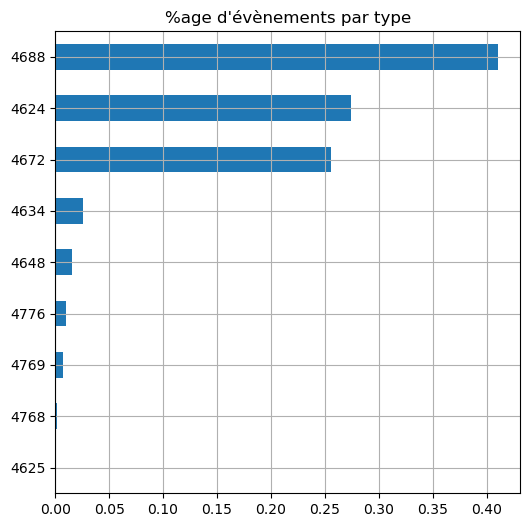

In [21]:
fig, ax = plt.subplots(figsize=(6,6))

eventid_counts = df['EventID'].value_counts() / df['EventID'].value_counts().sum()

ax = eventid_counts.plot(kind='barh')
ax.set_title("%age d'évènements par type")
ax.invert_yaxis()
ax.grid(True)
plt.show()

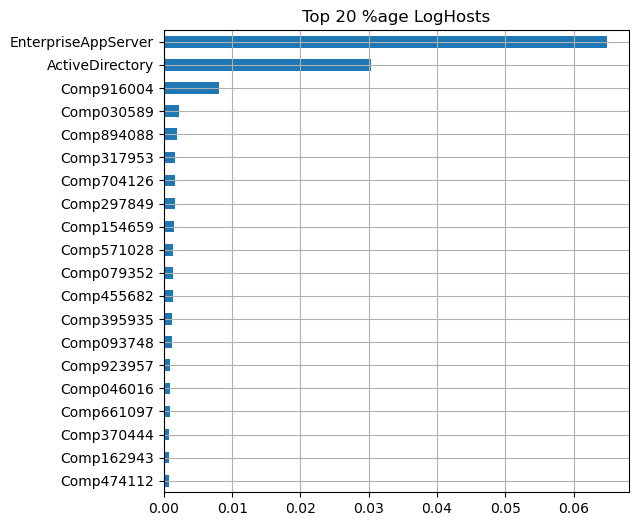

In [22]:
MAX_LOGHOSTS = 20

fig, ax = plt.subplots(figsize=(6,6))

loghost_counts = df['LogHost'].value_counts() / df['LogHost'].value_counts().sum()
ax = loghost_counts[:MAX_LOGHOSTS].plot(kind='barh')
ax.set_title(f"Top {MAX_LOGHOSTS} %age LogHosts")
ax.invert_yaxis()
ax.grid(True)
plt.show()

In [23]:
# MAX_LOGONIDS = 20

# fig, ax = plt.subplots(figsize=(6,6))

# logonids_counts = df['LogonID'].value_counts() / df['LogonID'].value_counts().sum()
# ax = logonids_counts[:MAX_LOGONIDS].plot(kind='barh')
# ax.set_title(f"Top {MAX_LOGONIDS} %age LogonIDs")
# ax.invert_yaxis()
# ax.grid(True)
# plt.show()

In [24]:
# MAX_LOGONTYPES = 20

# fig, ax = plt.subplots(figsize=(6,6))

# logontype_counts = df['LogonTypeDescription'].value_counts() / df['LogonTypeDescription'].value_counts().sum()
# ax = logontype_counts[:MAX_LOGONTYPES].plot(kind='barh')
# ax.set_title(f"Top {MAX_LOGONTYPES} %age LogonTypes")
# ax.invert_yaxis()
# ax.grid(True)
# plt.show()

In [25]:
# MAX_PROCESSNAMES = 20

# fig, ax = plt.subplots(figsize=(6,6))

# processname_counts = df['ProcessName'].value_counts() / df['ProcessName'].value_counts().sum()
# ax = processname_counts[:MAX_PROCESSNAMES].plot(kind='barh')
# ax.set_title(f"Top {MAX_PROCESSNAMES} %age ProcessNames")
# ax.invert_yaxis()
# ax.grid(True)
# plt.show()

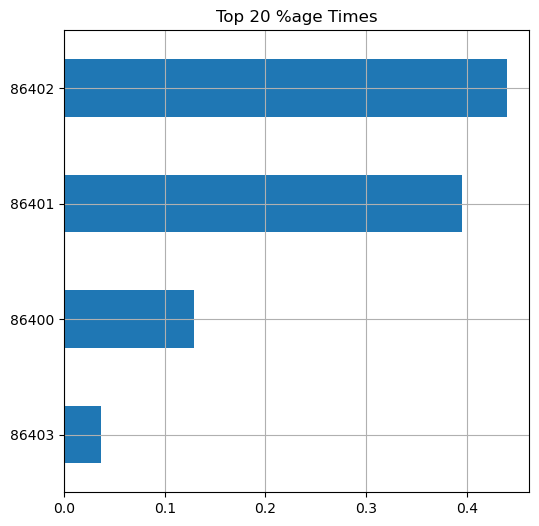

In [26]:
MAX_TIMES = 20

fig, ax = plt.subplots(figsize=(6,6))

times_counts = df['Time'].value_counts() / df['Time'].value_counts().sum()
ax = times_counts[:MAX_TIMES].plot(kind='barh')
ax.set_title(f"Top {MAX_TIMES} %age Times")
ax.invert_yaxis()
ax.grid(True)
plt.show()

In [27]:
# MAX_FAILURE_REASONS = 20

# fig, ax = plt.subplots(figsize=(6,6))

# fr_counts = df['FailureReason'].value_counts() / df['FailureReason'].value_counts().sum()
# ax = fr_counts[:MAX_FAILURE_REASONS].plot(kind='barh')
# ax.set_title(f"Top {MAX_FAILURE_REASONS} %age Failure Reason")
# ax.invert_yaxis()
# ax.grid(True)
# plt.show()

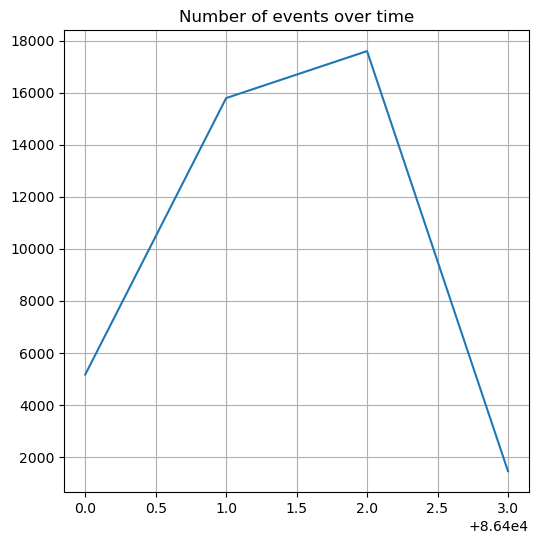

In [28]:
fig, ax = plt.subplots(figsize=(6,6))

ax = df['Time'].value_counts(sort=False).plot()
ax.set_title('Number of events over time')
ax.grid(True)

# Get a DataFrame from one record and transform it into categorical data

In [29]:
N = 40000 #index of the file to process, number of samples

In [30]:
df = get_df_from_file(n_eda=N)

Charge wls_day-02_subset_all_events_40000.json et créée une DataFrame


In [31]:
df

,UserName,EventID,LogHost,LogonID,DomainName,ParentProcessName,ParentProcessID,ProcessName,Time,ProcessID,...,Source,AuthenticationPackage,LogonType,Destination,SubjectUserName,SubjectLogonID,SubjectDomainName,Status,ServiceName,FailureReason
0,Comp883524$,4688,Comp883524,0x3e7,Domain001,svchost,0x35c,wmiprvse.exe,86400,0x1db4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,User805641,4688,Comp836249,0x45a5847,Domain001,Proc028501,0x3a8c,Proc542756.exe,86400,0x3314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Comp397468$,4688,Comp397468,0x3e7,Domain001,services,0x2b8,svchost.exe,86400,0xc770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Comp916004$,4672,Comp916004,0x32bba0c8,Domain001,NaN,NaN,NaN,86400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Comp916004$,4624,Comp916004,0x32bba0c8,Domain001,NaN,NaN,NaN,86400,NaN,...,Comp916004,Kerberos,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,Comp276131$,4688,Comp276131,0x3e7,Domain001,services,0x284,rundll32.exe,86403,0x1dc4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39996,system,4624,Comp276131,0x3e7,nt authority,NaN,NaN,services.exe,86403,0x284,...,NaN,Negotiate,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39997,system,4672,Comp276131,0x3e7,nt authority,NaN,NaN,NaN,86403,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39998,system,4624,Comp829475,0x3e7,nt authority,NaN,NaN,services.exe,86403,0x2b0,...,NaN,Negotiate,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserName               40000 non-null  object 
 1   EventID                40000 non-null  int64  
 2   LogHost                40000 non-null  object 
 3   LogonID                39269 non-null  object 
 4   DomainName             40000 non-null  object 
 5   ParentProcessName      16418 non-null  object 
 6   ParentProcessID        16418 non-null  object 
 7   ProcessName            27021 non-null  object 
 8   Time                   40000 non-null  int64  
 9   ProcessID              27021 non-null  object 
 10  LogonTypeDescription   12023 non-null  object 
 11  Source                 1851 non-null   object 
 12  AuthenticationPackage  11367 non-null  object 
 13  LogonType              12023 non-null  float64
 14  Destination            621 non-null    object 
 15  Su

In [33]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserName,40000,6177,system,18690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EventID,40000.0,NaN,NaN,NaN,4665.845,30.485409,4624.0,4624.0,4672.0,4688.0,4776.0
LogHost,40000,5938,EnterpriseAppServer,2594,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogonID,39269,2001,0x3e7,34847,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DomainName,40000,7,Domain001,21138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ParentProcessName,16418,59,services,14640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ParentProcessID,16418,903,0x2e4,474,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProcessName,27021,116,services.exe,9354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,40000.0,NaN,NaN,NaN,86401.38345,0.753081,86400.0,86401.0,86401.0,86402.0,86403.0
ProcessID,27021,4258,0x2e4,312,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Nettoyage

In [34]:
df = replace_nans(df)

df['UserNameAndDomainName'] = df['UserName'] + '_' + df['DomainName']

### Traitement des données

In [35]:
def process_df_into_cat(df=df):
    """Process DataFrame from wls into a DataFrame with integer-based categorical values, 
    except time, that remains as is.

    Args:
        df (_type_, optional): Dataframe issued from a wls file. Defaults to df.
    """
    
    # create a unique identifier for the user
    df['UserNameAndDomainName'] = df['UserName'] + '_' + df['DomainName']
    
    # manages all columns except Time
    columns = list(df.columns)
    columns.remove('Time')
    for c in columns:
        c_new = c + '_code'
        df[c_new] = df[c].astype("category").cat.codes
        
    df.drop(columns=columns, inplace=True)
    return df

In [36]:
df = process_df_into_cat(df=df)

In [37]:
df

,Time,UserName_code,EventID_code,LogHost_code,LogonID_code,DomainName_code,ParentProcessName_code,ParentProcessID_code,ProcessName_code,ProcessID_code,...,AuthenticationPackage_code,LogonType_code,Destination_code,SubjectUserName_code,SubjectLogonID_code,SubjectDomainName_code,Status_code,ServiceName_code,FailureReason_code,UserNameAndDomainName_code
0,86400,5210,5,5222,1018,1,56,529,116,993,...,4,0,4,15,32,1,4,24,2,5214
1,86400,6127,5,4935,1026,1,0,566,52,2307,...,4,0,4,15,32,1,4,24,2,6132
2,86400,2309,5,2314,1018,1,54,452,110,3970,...,4,0,4,15,32,1,4,24,2,2313
3,86400,5408,4,5422,970,1,50,903,100,4258,...,4,0,4,15,32,1,4,24,2,5412
4,86400,5408,0,5422,970,1,50,903,100,4258,...,0,2,4,15,32,1,4,24,2,5412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,86403,1602,5,1603,1018,1,54,422,106,997,...,4,0,4,15,32,1,4,24,2,1606
39996,86403,6175,0,1603,1018,5,50,903,109,1703,...,3,4,4,15,32,1,4,24,2,6180
39997,86403,6175,4,1603,1018,5,50,903,100,4258,...,4,0,4,15,32,1,4,24,2,6180
39998,86403,6175,0,4888,1018,5,50,903,109,1872,...,3,4,4,15,32,1,4,24,2,6180


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Time                        40000 non-null  int64
 1   UserName_code               40000 non-null  int16
 2   EventID_code                40000 non-null  int8 
 3   LogHost_code                40000 non-null  int16
 4   LogonID_code                40000 non-null  int16
 5   DomainName_code             40000 non-null  int8 
 6   ParentProcessName_code      40000 non-null  int8 
 7   ParentProcessID_code        40000 non-null  int16
 8   ProcessName_code            40000 non-null  int8 
 9   ProcessID_code              40000 non-null  int16
 10  LogonTypeDescription_code   40000 non-null  int8 
 11  Source_code                 40000 non-null  int16
 12  AuthenticationPackage_code  40000 non-null  int8 
 13  LogonType_code              40000 non-null  int8 
 14  Destin

In [39]:
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Time,40000.0,86401.383450,0.753081,86400.0,86401.0,86401.0,86402.0,86403.0
UserName_code,40000.0,4369.492675,2262.337871,0.0,2489.0,5917.0,6175.0,6176.0
EventID_code,40000.0,3.307275,2.159276,0.0,0.0,4.0,5.0,8.0
LogHost_code,40000.0,3081.772550,1867.927899,0.0,1451.0,3098.0,4749.0,5937.0
LogonID_code,40000.0,1035.584375,227.334633,0.0,1018.0,1018.0,1018.0,2001.0
DomainName_code,40000.0,2.879300,1.996167,0.0,1.0,1.0,5.0,6.0
ParentProcessName_code,40000.0,51.230450,4.085800,0.0,50.0,50.0,54.0,59.0
ParentProcessID_code,40000.0,721.121700,227.893103,0.0,474.0,903.0,903.0,903.0
ProcessName_code,40000.0,104.201425,10.287407,0.0,100.0,106.0,109.0,116.0
ProcessID_code,40000.0,2621.269600,1454.723713,0.0,1493.0,2270.5,4258.0,4258.0


# PCA - baseline

In [40]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [41]:
CHOICE = 'kernel' # ou 'lineaire'

### 2D

In [42]:
if CHOICE=='lineaire':
    pca2d = PCA(n_components=2)
else:
    pca2d = KernelPCA(n_components=2, kernel='rbf', gamma=1.0)

pca2d.fit(df)

KernelPCA(gamma=1.0, kernel='rbf', n_components=2)

In [43]:
if CHOICE=='lineaire':
    print(pca2d.explained_variance_ratio_)

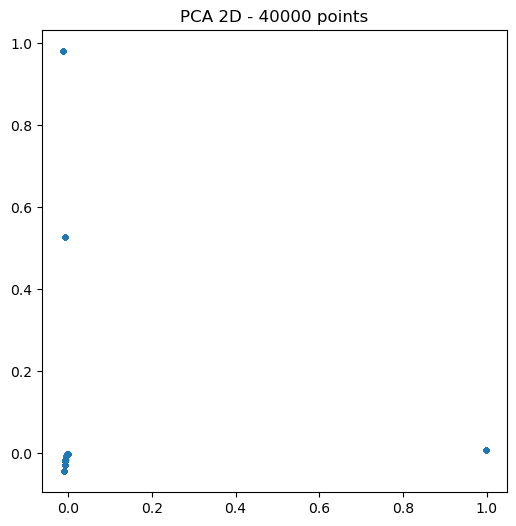

In [44]:
X_red2d = pca2d.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(X_red2d[:,0], X_red2d[:,1], marker='.')
ax.set_title(f'PCA 2D - {N} points')
plt.show()

### 3D

In [45]:
if CHOICE=='lineaire':
    pca3d = PCA(n_components=3)
else:
    pca3d = KernelPCA(n_components=3, kernel='rbf', gamma=1.0)

pca3d.fit(df)

KernelPCA(gamma=1.0, kernel='rbf', n_components=3)

In [46]:
if CHOICE=='lineaire':
    print(pca3d.explained_variance_ratio_)

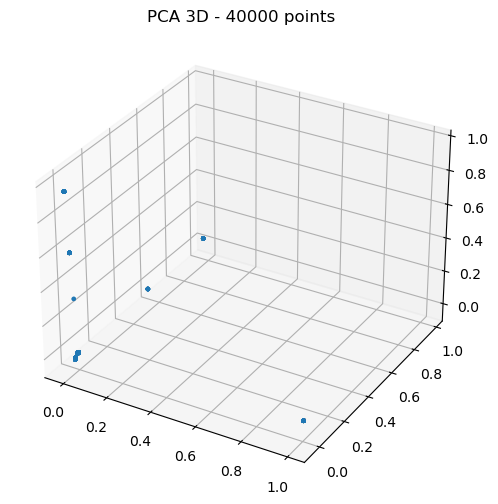

In [47]:
X_red = pca3d.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], marker='.')
ax.set_title(f'PCA 3D - {N} points')
plt.show()

### Un peu d'explications

In [48]:
def get_df_expl(pca, df=df):
    """return a Dataframe with explained variance ratio and decomposition of eigenvectors in pca model

    Args:
        pca (_type_): pca model, already fit
        df (_type_, optional): original dataframe. Defaults to df.
    """
    
    # to loop over number of components
    n_components = range(pca.n_components_)
    
    # build a dictionnary of n eigenvectors, each value is the list of coordinates in data space
    dict_eigenvectors = {
    n : list(pca.components_[n,:]) for n in n_components
}

    # build full dictionnary to pass to DF constructor
    dict = {
    'Explained_Variance_Ratio' : list(pca.explained_variance_ratio_),
}

    columns = list(df.columns)

    for i, c in enumerate(columns):
        dict[c] = [ dict_eigenvectors[j][i] for j in n_components]
        
    # build and return dataframe
    df_expl = pd.DataFrame.from_dict(data=dict)
    
    return df_expl

In [49]:
if CHOICE=='lineaire':
    df_expl = get_df_expl(pca3d, df)
    df_expl.transpose()

### Generalization to n eigenvectors > 3

In [50]:
N_COMPONENTS = 5

In [51]:
if CHOICE=='lineaire':
    pca5d = PCA(n_components=N_COMPONENTS)
else:
    pca5d = KernelPCA(n_components=N_COMPONENTS, kernel='rbf', gamma=5.0)

pca5d.fit(df)

KernelPCA(gamma=5.0, kernel='rbf', n_components=5)

In [52]:
if CHOICE=='lineaire':
    print(pca5d.explained_variance_ratio_)

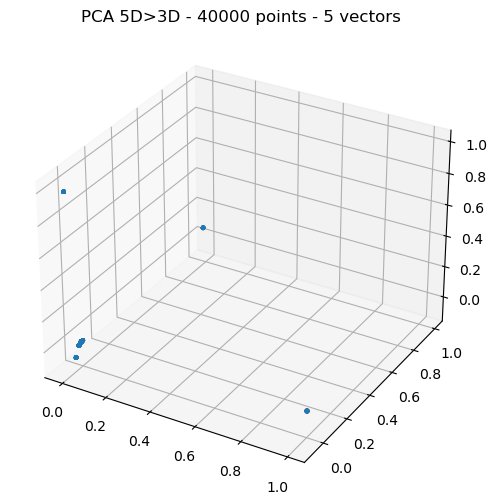

In [53]:
X_red = pca5d.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], marker='.')
ax.set_title(f'PCA 5D>3D - {N} points - {N_COMPONENTS} vectors')
plt.show()

In [54]:
if CHOICE=='lineaire':
    df_expl = get_df_expl(pca5d, df)
    df_expl.transpose()

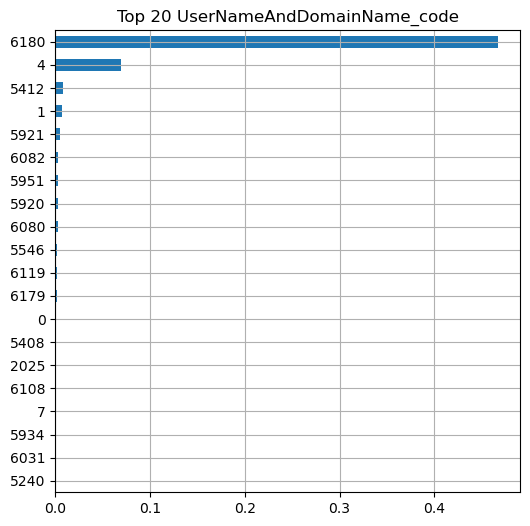

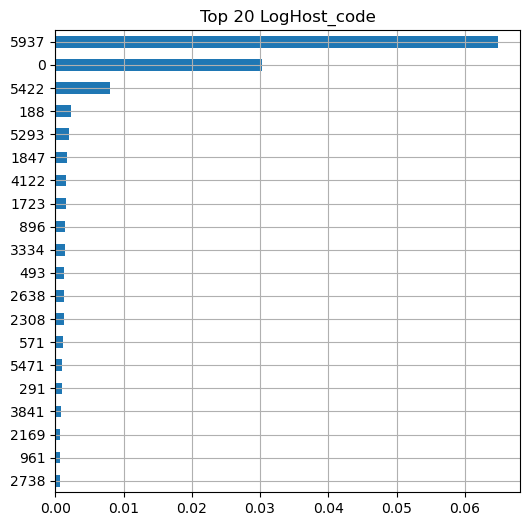

In [55]:
# regardons UserName_code, LogHost_code, Source_code

list_columns = ['UserNameAndDomainName_code', 'LogHost_code'] #, 'Source_code']
MAX_CAT = 20

for c in list_columns:
    fig, ax = plt.subplots(figsize=(6,6))

    counts = df[c].value_counts() / df[c].value_counts().sum()
    ax = counts[:MAX_CAT].plot(kind='barh')
    ax.set_title(f"Top {MAX_CAT} " + c)
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()

# Kernel Density Estimation

In [56]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [57]:
# # grid search to find the best bandwith

# params = {"bandwidth" : np.logspace(0,1,3)}
# grid = GridSearchCV(KernelDensity(), params, cv=3,n_jobs=-1, verbose=3)
# grid.fit(df.to_numpy())

# print(f"Meilleur bandwidth : {grid.best_estimator_.bandwidth}")

# # utilise le meilleur estimateur

# kde = grid.best_estimator_

# ou bien, inéfrence directe

kde = KernelDensity(bandwidth=1.0).fit(df.to_numpy())


In [58]:
# scores = [ kde.score(df.iloc[i].to_numpy().reshape(1,-1)) for i in range(len(df)) ]

scores = kde.score_samples(df.to_numpy())

In [59]:
scores.shape

(40000,)

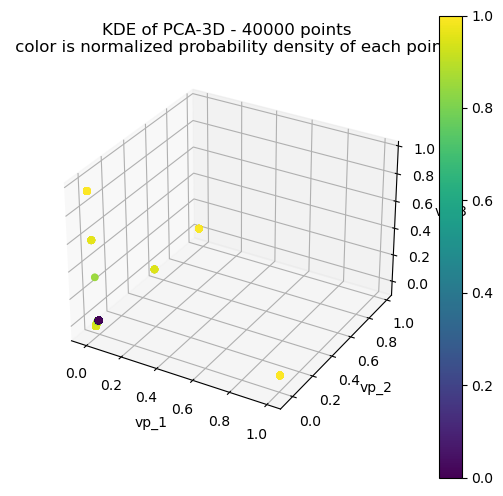

In [60]:
# 3D display of projected points on PCA manifold

# if CHOICE=='lineaire':
#     pca = PCA(n_components=3)
# else:
#     pca = KernelPCA(n_components=3, kernel='rbf', gamma=5.0)
    
# X_red = pca.fit_transform(df)

X_red = pca3d.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# invoke color map
cmap = plt.cm.viridis

# create normalizing object to map values into color map
vmin = np.min(scores)
vmax = np.max(scores)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

# instantiate 3d object
p = ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=cmap(norm(scores)), marker='o') # 
ax.set_title(f'KDE of PCA-3D - {N} points \n color is normalized probability density of each point')
ax.set_xlabel('vp_1')
ax.set_ylabel('vp_2')
ax.set_zlabel('vp_3')

# display color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(p, ax=ax)

plt.show()

# Variational Bayesian Gaussian Mixture

In [61]:
from sklearn.mixture import BayesianGaussianMixture

In [62]:
N_RESPONSIBILITIES_MAX = min(10,int(N / 100))
print(f'Max = {N_RESPONSIBILITIES_MAX} components')

Max = 10 components


In [63]:
dpbgm = BayesianGaussianMixture(
    n_components = N_RESPONSIBILITIES_MAX, # max number of components, will be infered by data
    weight_concentration_prior_type = 'dirichlet_process',   # weight concentration prior is Dirchlet process : (approximate) infinite number of components
    random_state = 42,
    # reg_covar = 1e-6,
    verbose = 3,
    max_iter = 1000,
)

In [64]:
dpbgm.fit(df.to_numpy())

Initialization 0
  Iteration 10	 time lapse 8.64857s	 ll change 1102.61521
  Iteration 20	 time lapse 7.67755s	 ll change -0.20874
  Iteration 30	 time lapse 6.35025s	 ll change 1.63801
  Iteration 40	 time lapse 6.18019s	 ll change -0.41267
  Iteration 50	 time lapse 6.76599s	 ll change 0.20639
Initialization converged: True	 time lapse 37.00619s	 ll 1421607.91646


BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        verbose=3)

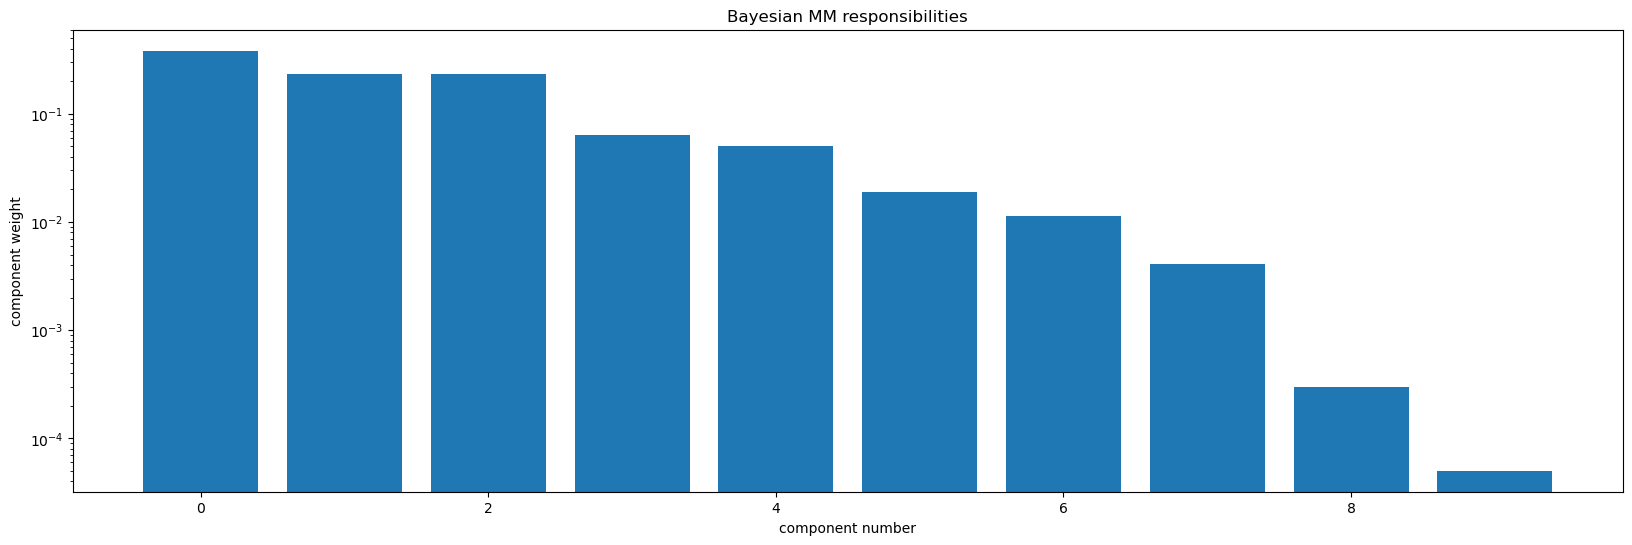

In [65]:
comp_number = [ x for x in range(N_RESPONSIBILITIES_MAX) ]
responsibilities = sorted(list(dpbgm.weights_),reverse=True)

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(comp_number, responsibilities)
ax.set_xlabel('component number')
ax.set_ylabel('component weight')
ax.set_yscale("log")
ax.set_title(f'Bayesian MM responsibilities')
plt.show()

In [66]:
# get responsibilities per point
probas = dpbgm.predict_proba(df.to_numpy())

# get predicted label, and associated responsibility, per data point
labels = np.argmax(probas, axis=1)
certainty = np.max(probas, axis=1)

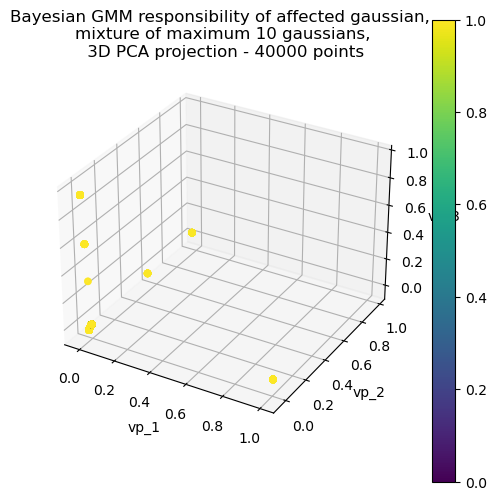

In [67]:
# 3D display of Bayesian GMM - projected points on PCA manifold
# if CHOICE=='lineaire':
#     pca = PCA(n_components=3)
# else:
#     pca = KernelPCA(n_components=3, kernel='rbf', gamma=5.0)
    
# X_red = pca.fit_transform(df)

X_red = pca3d.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# invoke color map
cmap = plt.cm.viridis

# create normalizing object to map labels values into color map
vmin = np.min(certainty)
vmax = np.max(certainty)
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

# instantiate 3d object
p = ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=cmap(norm(certainty)), marker='o') # 
ax.set_title(f'Bayesian GMM responsibility of affected gaussian, \nmixture of maximum {N_RESPONSIBILITIES_MAX} gaussians,\n 3D PCA projection - {N} points')
ax.set_xlabel('vp_1')
ax.set_ylabel('vp_2')
ax.set_zlabel('vp_3')

# display color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(p, ax=ax)

plt.show()

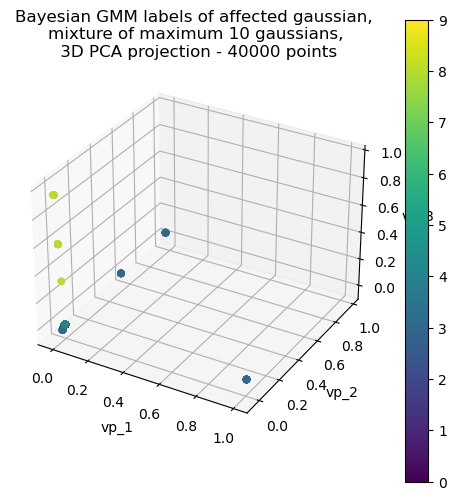

In [68]:
# 3D display of Bayesian GMM - projected points on PCA manifold
# if CHOICE=='lineaire':
#     pca = PCA(n_components=3)
# else:
#     pca = KernelPCA(n_components=3, kernel='rbf', gamma=5.0)
    
# X_red = pca.fit_transform(df)

X_red = pca3d.transform(df)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# invoke color map
cmap = plt.cm.viridis

# create normalizing object to map labels values into color map
vmin = np.min(labels)
vmax = np.max(labels)
# norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

# instantiate 3d object
p = ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], c=labels, marker='o') # 
ax.set_title(f'Bayesian GMM labels of affected gaussian, \nmixture of maximum {N_RESPONSIBILITIES_MAX} gaussians,\n 3D PCA projection - {N} points')
ax.set_xlabel('vp_1')
ax.set_ylabel('vp_2')
ax.set_zlabel('vp_3')

# display color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(p, ax=ax)

plt.show()

# VAE (inspiré du tuto Keras by F Chollet)

In [69]:
# Sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent variable encoding an input."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(42)

    def call(self, inputs):
        z_mean, z_log_var = inputs  # log var plutôt que l'écart type
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        # reparametrisation trick from original article Kingma and Welling, “Auto-Encoding Variational Bayes”, ICLR 2014
        scale = 0.25 # tentative de diminuer le bruit pour éviter le posterior collapse... on sample "étroit" ?
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon * scale

In [70]:
df.to_numpy().shape

(40000, 22)

In [71]:
points = df.to_numpy()

In [72]:
input_dim = points.shape[-1]
output_dim = input_dim
latent_dim = 2

In [73]:
# Encoder

encoder_inputs = keras.Input(shape=(input_dim,))

# basic MLP
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)

# output mean et log_var de la gaussienne
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# sample de la gaussienne inférée par le MLP
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      5,888 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        130 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        130 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,300 (184.77 KB)

 Trainable params: 47,300 (184.77 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Decoder

# input : vecteur de l'espace latent
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(64, activation="relu")(latent_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)

decoder_outputs = layers.Dense(output_dim)(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 22)             │         5,654 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,190 (184.34 KB)

 Trainable params: 47,190 (184.34 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Classe VAE

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        # encodeur vers l'espace latent
        self.encoder = encoder
        # décodeur depuis l'espace latent
        self.decoder = decoder
        # losses
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # une étape de forward pass, avec différentiation des losses
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)  # forward pass de l'encodeur
            reconstruction = self.decoder(z)  # veceteur reconstruit depuis la variable latent samplée
            # 1ere loss : erreur reconstruction entre la data et la reconstruction
            reconstruction_loss = ops.mean(keras.losses.mean_squared_error(data, reconstruction)),  # norme L2 pour calculer l'erreur de reconstruction
            # 2e loss : KL entre le posterior z|x appris par l'encodeur et N(0,I) cible
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            # loss totale (ELBO)
            total_loss = reconstruction_loss + kl_loss
            
        # calcul des gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [76]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()

s.fit(points)

x_train = s.transform(points)

In [77]:
# basic training

vae = VAE(encoder, decoder)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    restore_best_weights=True,
    # mode='min'
)

vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=1000, batch_size=128, callbacks=[callback])

Epoch 1/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - kl_loss: 0.0603 - loss: 0.9048 - reconstruction_loss: 0.8446
Epoch 2/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - kl_loss: 0.1381 - loss: 0.6568 - reconstruction_loss: 0.5186
Epoch 3/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - kl_loss: 0.1456 - loss: 0.5956 - reconstruction_loss: 0.4501
Epoch 4/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - kl_loss: 0.1569 - loss: 0.5808 - reconstruction_loss: 0.4239
Epoch 5/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - kl_loss: 0.1639 - loss: 0.5805 - reconstruction_loss: 0.4166
Epoch 6/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - kl_loss: 0.1648 - loss: 0.5739 - reconstruction_loss: 0.4091
Epoch 7/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - kl_loss: 0.1589 - loss: 0.5641 - reconstruction_loss: 0.4051
Epoch 8/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - kl_loss: 0.1658 - loss: 0.5384 - reconstruction_loss: 0.3726
Epoch 9/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step 

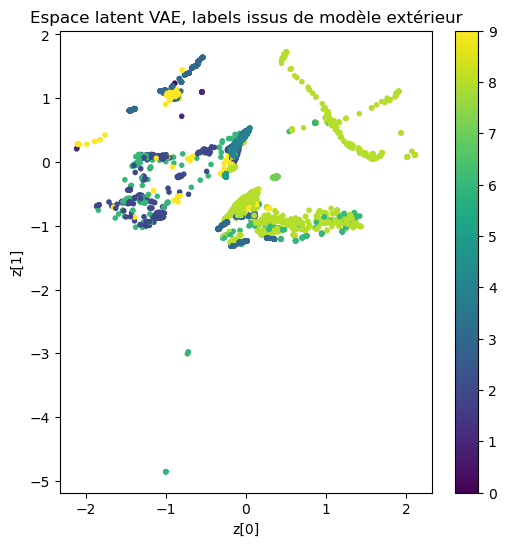

In [78]:
# Display latent space

def plot_label_clusters(vae, data, labels):
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    # display a 2D plot of the latent space
    z_mean, _, _ = vae.encoder.predict(s.transform(data), verbose=0)
    # plt.figure(figsize=(6, 6))
    ax.scatter(z_mean[:, 0], z_mean[:, 1], marker='.', c=labels)  # reuse les labels issus du bayesian GMM
    # plt.colorbar()
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")
    
    # invoke color map
    cmap = plt.cm.viridis
    # create normalizing object to map labels values into color map
    vmin = np.min(labels)
    vmax = np.max(labels)
    # display color map
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(p, ax=ax)
    ax.set_title(f'Espace latent VAE, labels issus de modèle extérieur')
        
    plt.show()

plot_label_clusters(vae, points, labels)

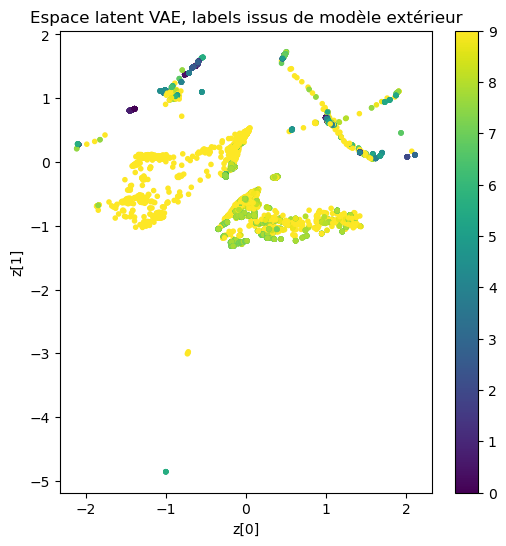

In [79]:
plot_label_clusters(vae, points, -scores)

# One Class SVM

In [80]:
latent_points = vae.encoder.predict(s.transform(points))[0]  # récupére les z_mean samplées dns l'espace latent de dim 2.

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step


In [81]:
latent_points

array([[-0.08660164,  0.285724  ],
       [-1.6290078 , -0.87894255],
       [-0.05888768,  0.3506208 ],
       ...,
       [-0.25143525, -0.22406548],
       [ 0.36012945, -0.23830879],
       [-0.25770435, -0.21230838]], dtype=float32)

In [82]:
clf = OneClassSVM(kernel='rbf', gamma='scale').fit(latent_points)  # classifier dans l'espace latent dim 2

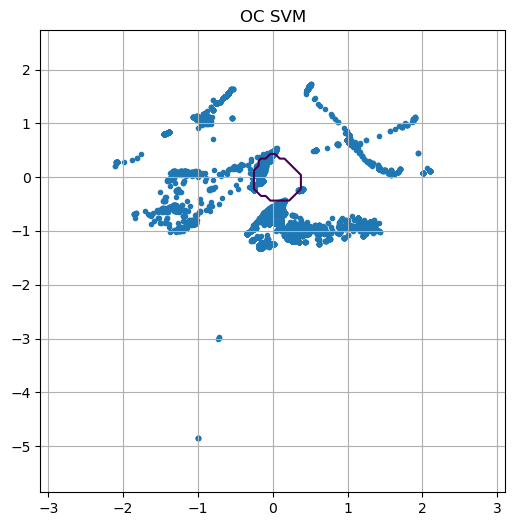

In [83]:
from sklearn.inspection import DecisionBoundaryDisplay

# fig, ax = display_dataset(points, labels, mus, covs, sigma_max)

fig, ax = plt.subplots(figsize=(6,6))

DecisionBoundaryDisplay.from_estimator(
    estimator=clf,
    X=latent_points,
    response_method="predict",
    plot_method="contour",
    levels=[0,1,2,3,4,5],
    ax=ax
)

ax.scatter(latent_points[:,0], latent_points[:,1], marker='.')

ax.set_title('OC SVM')
ax.grid(True)

plt.show()